Top 10 documentos más similares:
documento_23.txt - documento_29.txt: 4.54545%
documento_65.txt - documento_83.txt: 4.02145%
documento_26.txt - documento_49.txt: 3.95778%
documento_76.txt - documento_99.txt: 3.76344%
documento_57.txt - documento_58.txt: 3.76344%
documento_39.txt - documento_78.txt: 3.76344%
documento_42.txt - documento_60.txt: 3.75335%
documento_2.txt - documento_79.txt: 3.74332%
documento_57.txt - documento_92.txt: 3.73333%
documento_22.txt - documento_36.txt: 3.73333%

📊 Top 10 documentos más similares:

╒══════════════════╤══════════════════╤═════════════╕
│ Documento 1      │ Documento 2      │ Similitud   │
╞══════════════════╪══════════════════╪═════════════╡
│ documento_23.txt │ documento_29.txt │ 4.55%       │
├──────────────────┼──────────────────┼─────────────┤
│ documento_65.txt │ documento_83.txt │ 4.02%       │
├──────────────────┼──────────────────┼─────────────┤
│ documento_26.txt │ documento_49.txt │ 3.96%       │
├──────────────────┼──────────────────┼

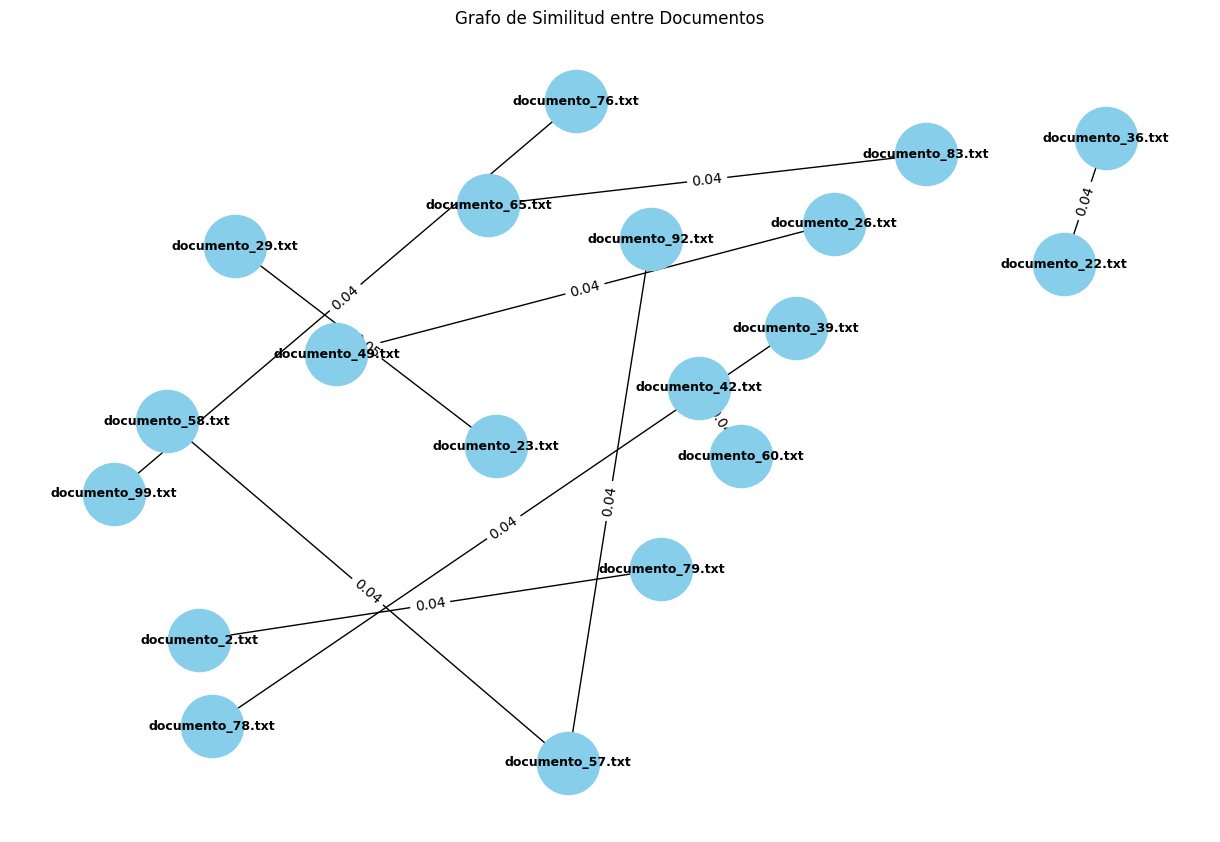

Gráfico guardado en: c:\Users\evert\Desktop\TSU DS segundo cuatri\estructura de datos\Proyecto unidad III\detector-plagio\resultados\relación_similitudes_grafos.png


In [ ]:
import os
import random
from itertools import combinations
from pathlib import Path
import string
from pybloom_live import BloomFilter
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. Generar documentos

def generar_txts(carpeta, cantidad=100):
    os.makedirs(carpeta, exist_ok=True)
    palabras_base = [
        "estudiante", "universidad", "tarea", "plagio", "docente", "investigaci\u00f3n", "ciencia",
        "aprendizaje", "conocimiento", "disciplina", "m\u00e9todo", "estudio", "ensayo", "an\u00e1lisis", "criterio",
        "creatividad", "descubrimiento", "innovaci\u00f3n", "teor\u00eda",
    ]
    for i in range(cantidad):
        contenido = " ".join(random.choices(palabras_base, k=200))
        with open(os.path.join(carpeta, f"documento_{i+1}.txt"), "w", encoding="utf-8") as f:
            f.write(contenido)

# 2. Preprocesamiento

def preprocesar_texto(texto, n=2):
    texto = texto.lower()
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    palabras = texto.split()
    ngramas = [" ".join(palabras[i:i+n]) for i in range(len(palabras)-n+1)]
    return ngramas

# 3. Hash personalizado

def hash_personalizado(ngram):
    valor_hash = 0
    for char in ngram:
        valor_hash = (valor_hash * 31 + ord(char)) % (10**9 + 7)
    return valor_hash

# 4. Construir tabla hash y/o Bloom Filter

def construir_tabla_bloom(documentos, usar_bloom=False, n=3):
    tablas = {}
    ngramas_originales = {}  # guardamos los ngramas para comparación posterior
    for nombre, texto in documentos.items():
        ngramas = preprocesar_texto(texto, n)
        ngramas_originales[nombre] = ngramas
        if usar_bloom:
            bloom = BloomFilter(capacity=1000, error_rate=0.001)
            for ng in ngramas:
                bloom.add(ng)
            tablas[nombre] = bloom
        else:
            tablas[nombre] = set(hash(ng) for ng in ngramas)
    return tablas, ngramas_originales

# 5. Cargar documentos

def cargar_documentos(ruta, n=2):
    documentos = {}
    for archivo in os.listdir(ruta):
        if archivo.endswith(".txt"):
            with open(os.path.join(ruta, archivo), "r", encoding="utf-8") as f:
                contenido = f.read()
                documentos[archivo] = contenido
    return documentos

# 6. Comparar documentos usando similitud de Jaccard (solo para sets)

def similitud_jaccard(set1, set2):
    interseccion = len(set1 & set2)
    union = len(set1 | set2)
    return interseccion / union if union != 0 else 0

def comparar_documentos(tablas, usar_bloom=False, ngramas_originales=None):
    similitudes = []
    for doc1, doc2 in combinations(tablas.keys(), 2):
        if usar_bloom:
            # Usamos los ngramas de doc1 para comprobar si están en el filtro de doc2
            interseccion = sum(1 for ng in ngramas_originales[doc1] if ng in tablas[doc2])
            union = len(set(ngramas_originales[doc1])) + len(set(ngramas_originales[doc2])) - interseccion
            sim = interseccion / union if union != 0 else 0
        else:
            sim = similitud_jaccard(tablas[doc1], tablas[doc2])
        similitudes.append((doc1, doc2, sim))
    return similitudes


# 7. Ordenamiento y visualización

def merge_sort(lista):
    if len(lista) > 1:
        mid = len(lista) // 2
        izquierda = lista[:mid]
        derecha = lista[mid:]

        merge_sort(izquierda)
        merge_sort(derecha)

        i = j = k = 0
        while i < len(izquierda) and j < len(derecha):
            if izquierda[i][2] > derecha[j][2]:
                lista[k] = izquierda[i]
                i += 1
            else:
                lista[k] = derecha[j]
                j += 1
            k += 1

        while i < len(izquierda):
            lista[k] = izquierda[i]
            i += 1
            k += 1

        while j < len(derecha):
            lista[k] = derecha[j]
            j += 1
            k += 1

def mostrar_top_similares(similitudes, top_n=10):
    merge_sort(similitudes)
    print("Top", top_n, "documentos más similares:")
    for i in range(min(top_n, len(similitudes))):
        print(f"{similitudes[i][0]} - {similitudes[i][1]}: {similitudes[i][2]*100:.5f}%")


# 8. Visualizar grafo de similitudes
def visualizar_similitudes(similitudes, nombre_archivo="grafo_similitudes.png"):
    # Crear la ruta de destino
    ruta_escritorio = Path.cwd().parent / "resultados"
    ruta_escritorio.mkdir(parents=True, exist_ok=True)  # Crear directorio si no existe
    ruta_completa = ruta_escritorio / nombre_archivo
    
    G = nx.Graph()
    for doc1, doc2, sim in similitudes:
        if sim > 0:
            G.add_edge(doc1, doc2, weight=round(sim, 2))

    pos = nx.spring_layout(G, k=0.15, iterations=2)  
    etiquetas = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=9, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=etiquetas)
    plt.title("Grafo de Similitud entre Documentos")
    
    # Guardar la imagen antes de mostrarla
    plt.savefig(ruta_completa, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico guardado en: {ruta_completa}")
    
# 9. Visualizar Resultados en Tabla
def mostrar_tabla(similitudes):
    headers = ["Documento 1", "Documento 2", "Similitud"]
    tabla = [(d1, d2, f"{sim*100:.2f}%") for d1, d2, sim in similitudes[:10]]
    print("\n📊 Top 10 documentos más similares:\n")
    print(tabulate(tabla, headers=headers, tablefmt="fancy_grid"))
def mostrar_tabla(similitudes):
    # Configurar rutas
    ruta_escritorio = Path.cwd().parent / "resultados"
    ruta_escritorio.mkdir(parents=True, exist_ok=True)  # Crear directorio si no existe
    ruta_archivo = ruta_escritorio / "resultados_similitud.txt"
    
    # Generar contenido de la tabla
    headers = ["Documento 1", "Documento 2", "Similitud"]
    tabla = [(d1, d2, f"{sim*100:.2f}%") for d1, d2, sim in similitudes[:10]]
    tabla_formateada = tabulate(tabla, headers=headers, tablefmt="fancy_grid")
    
    # Mostrar por consola
    print("\n📊 Top 10 documentos más similares:\n")
    print(tabla_formateada)
    
    # Guardar en archivo
    with open(ruta_archivo, "w", encoding="utf-8") as f:
        f.write("RESULTADOS DE SIMILITUD ENTRE DOCUMENTOS\n")
        f.write("="*50 + "\n\n")
        f.write(tabla_formateada)
    
    print(f"\n✅ Tabla guardada en: {ruta_archivo}\n")    
    
# 10. Ejecutar
ruta_escritorio = Path.cwd().parent / "documentos"
generar_txts(ruta_escritorio, 100)
documentos = cargar_documentos(ruta_escritorio)
tablas_bloom, ngramas_originales = construir_tabla_bloom(documentos, usar_bloom=True)
similitudes = comparar_documentos(tablas_bloom, usar_bloom=True, ngramas_originales=ngramas_originales)
mostrar_top_similares(similitudes, 10)
mostrar_tabla(similitudes)
visualizar_similitudes(similitudes[:10], "relación_similitudes_grafos.png")


In [8]:
#procesar TXT específicos
from pathlib import Path
ruta_documentos = Path.cwd().parent / "documentos"

archivo1 = ruta_documentos / "documento_1.txt"
archivo2 = ruta_documentos / "documento_2.txt"

with open(archivo1, "r", encoding="utf-8") as f1:
    texto1 = f1.read()

with open(archivo2, "r", encoding="utf-8") as f2:
    texto2 = f2.read()
    
ngramas1 = preprocesar_texto(texto1, n=2)
ngramas2 = preprocesar_texto(texto2, n=2)

set1 = set(ngramas1)
set2 = set(ngramas2)
similitud = similitud_jaccard(set1, set2)
print(f"Similitud Jaccard entre documento_1 y documento_2: {similitud:.5f}")



Similitud Jaccard entre documento_1 y documento_2: 0.29876


In [13]:
# procesar TXT específicos usando hash personalizado
from pathlib import Path

# Ruta a la carpeta "documentos"
ruta_documentos = Path.cwd().parent / "documentos"

# Seleccionamos los dos archivos
archivo1 = ruta_documentos / "documento_1.txt"
archivo2 = ruta_documentos / "documento_2.txt"

# Leemos el contenido de ambos archivos
with open(archivo1, "r", encoding="utf-8") as f1:
    texto1 = f1.read()

with open(archivo2, "r", encoding="utf-8") as f2:
    texto2 = f2.read()

# Preprocesamos y generamos bigramas
ngramas1 = preprocesar_texto(texto1, n=2)
ngramas2 = preprocesar_texto(texto2, n=2)

# Aplicamos el hash personalizado a cada n-grama
set1 = set(hash_personalizado(ng) for ng in ngramas1)
set2 = set(hash_personalizado(ng) for ng in ngramas2)

# Calculamos la similitud Jaccard entre los hashes
similitud = similitud_jaccard(set1, set2)

# Mostramos el resultado
print(f"Similitud Jaccard entre documento_1 y documento_2 es de: {similitud*100:.2f}%")


Similitud Jaccard entre documento_1 y documento_2 es de: 27.12%


In [10]:
from pathlib import Path

ruta_documentos = Path.cwd().parent/ "documentos"
print("Buscando archivos en:", ruta_documentos)

for archivo in ruta_documentos.iterdir():
    print(archivo.name)


Buscando archivos en: c:\Users\evert\Desktop\TSU DS segundo cuatri\estructura de datos\Proyecto unidad III\detector-plagio\documentos
documento_1.txt
documento_10.txt
documento_100.txt
documento_11.txt
documento_12.txt
documento_13.txt
documento_14.txt
documento_15.txt
documento_16.txt
documento_17.txt
documento_18.txt
documento_19.txt
documento_2.txt
documento_20.txt
documento_21.txt
documento_22.txt
documento_23.txt
documento_24.txt
documento_25.txt
documento_26.txt
documento_27.txt
documento_28.txt
documento_29.txt
documento_3.txt
documento_30.txt
documento_31.txt
documento_32.txt
documento_33.txt
documento_34.txt
documento_35.txt
documento_36.txt
documento_37.txt
documento_38.txt
documento_39.txt
documento_4.txt
documento_40.txt
documento_41.txt
documento_42.txt
documento_43.txt
documento_44.txt
documento_45.txt
documento_46.txt
documento_47.txt
documento_48.txt
documento_49.txt
documento_5.txt
documento_50.txt
documento_51.txt
documento_52.txt
documento_53.txt
documento_54.txt
doc